# Decision Tree Notebook for Object Classification with SDSS DR18 

Within this notebook we use a decision tree neural network to predict the type of object in a given survey based upon the light from a target.

This is classed as a Galaxy, a Star, or a Quasar. These objects are described as follows: 

- [Galaxies](https://en.wikipedia.org/wiki/Galaxy) are systems of stars, stellar remnants, interstellar gas, dust, and dark matter bound together by gravity.
- [Stars](https://en.wikipedia.org/wiki/Star) are luminous spheroid of plasma held together by self-gravity.
- [Quasars](https://en.wikipedia.org/wiki/Quasar) are extremely luminous active galactic nucleus, it's also sometimes known as a quasi-stellar object or QSO.

The dataset used is from the eighteenth release of the Sloan Digital Sky Survey [(DR18)](https://www.sdss.org/dr18/), consisting of 100,000 astrophysical objects that can be classified based on visual parameters.

## Utilised Libraries

In order to perform any analysis, we need to import libraries in order to perform the decision tree classification. We will be using kagglehub, pandas, matplotlib and sklearn.

In [1]:
import kagglehub #used to get the data from kaggle.com
from kagglehub import KaggleDatasetAdapter #used to fetch the specific dataset from kaggle
import pandas as pd #used for viewing and manipulating the data
import matplotlib.pyplot as plt #used for data visulisation
import sklearn as skl
from sklearn.model_selection import train_test_split as skl_tts
from sklearn.tree import DecisionTreeClassifier as skl_dtc
from sklearn.metrics import classification_report as skl_cr
from sklearn.metrics import accuracy_score as skl_as
from sklearn.tree import plot_tree as plt_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#DO NOT TOUCH THIS - IT WORKS
import sys, os #imports sys and os, allows for modifying the path to get functions
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".."))) #changes the path to include the py folder and its contents (parent folder)

from functions import * #calls all functions from functions.py


## Calling the data

First, we have to retrieve the data, this is done via the dataGrabber function defined within our functions.py file - this takes the dataset from kaggle and imports it into python, saving it here as a variable data.

In [2]:
data = dataGrabber()

Then we can display just a small amount of the data using data.head(), with the max columns off to allow for the width of the entire dataset to be displayed within the notebook.

In [3]:
pd.set_option('display.max_columns', None)
data.head()

,objid,specobjid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,plate,mjd,fiberid,petroRad_u,petroRad_g,petroRad_i,petroRad_r,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_i,petroFlux_r,petroFlux_z,petroR50_u,petroR50_g,petroR50_i,petroR50_r,petroR50_z,psfMag_u,psfMag_r,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,1.240000e+18,3.240000e+17,184.950869,0.733068,18.87062,17.59612,17.11245,16.83899,16.70908,756,301,5,462,288,52000,456,7.282402,7.004576,6.855976,7.112749,6.930960,30.66393,95.11749,181.718400,146.991600,207.027300,3.832911,3.659077,3.486617,3.621753,3.606744,21.11891,19.50324,19.96352,19.25145,19.05230,0.479021,0.518483,0.520474,0.508502,0.488969,0.041691,GALAXY
1,1.240000e+18,3.250000e+17,185.729201,0.679704,19.59560,19.92153,20.34448,20.66213,20.59599,756,301,5,467,289,51990,322,1.335305,1.321027,1.167182,1.266144,0.966431,14.55308,10.33474,4.623398,7.371214,4.824737,0.653159,0.659008,0.536881,0.650679,0.538456,19.58945,20.34491,19.92417,20.65535,20.57387,0.573926,0.531728,0.403072,0.999874,0.189495,-0.000814,STAR
2,1.240000e+18,3.240000e+17,185.687690,0.823480,19.26421,17.87891,17.09593,16.65159,16.35329,756,301,5,467,288,52000,614,3.874802,3.952013,4.007457,4.057646,3.818449,19.31011,72.75911,220.896700,148.093400,278.021100,1.898399,1.993737,1.944997,1.968584,1.863368,20.82290,18.54832,19.33645,18.16669,17.78844,0.701666,0.743386,0.770897,0.778642,0.736771,0.113069,GALAXY
3,1.240000e+18,2.880000e+18,185.677904,0.768362,19.49739,17.96166,17.41269,17.20545,17.11567,756,301,5,467,2558,54140,414,1.251496,1.325716,1.176959,1.281164,1.199375,15.33828,62.74539,125.370700,104.867200,134.623300,0.633329,0.679328,0.611904,0.657945,0.622971,19.49706,17.42272,17.96176,17.21564,17.12367,0.999818,0.787760,0.745611,0.399718,0.986137,0.000087,STAR
4,1.240000e+18,2.880000e+18,185.814763,0.776940,18.31519,16.83033,16.26352,16.06320,15.97527,756,301,5,467,2558,54140,403,1.365736,1.336521,1.161740,1.266766,1.239413,45.91689,178.20720,359.093500,300.775600,388.320300,0.677250,0.680561,0.613476,0.655520,0.640669,18.33505,16.28580,16.85104,16.08275,15.98694,0.999795,0.834450,0.723526,0.712259,0.527055,0.000018,STAR


## Choosing features and selecting a target ##

These are the primary features we are using with our model from the data, as well as the target being the 'class' of the object. This can be easily changed however to any column from the dataset.

The features selected are as follows:
- u - the ultraviolet magnitude
- g - the green visible light magnitude
- r - the red visible light magnitude
- i - the infrared light at 7600 $\mathring{A}$
- z - the inrared light at 9100 $\mathring{A}$
- *redshift* - the redshift of the object (optional)

In [4]:
#main feature trying to find is subclass (starforming or starburst)
features = data[['u', 'g', 'r', 'i', 'z']] #, 'redshift'
target = data['class']

## Determining testing and training data

Next, we have to determine the size of our testing and training set, this allows us to train the decision tree with an amount of the data, then use the remainder to verify the model and determine its accuracy. In this case we use 80% of the data to train the model and 20% to verify its accuracy.

In [5]:
test_size = 0.2 #splits the data into 80:20 ratio, using 80% of the data to test 20% of the data
random_state = 12 #acts as a seed to ensure same outcome each time
xTrain, xTest, yTrain, yTest = dataSplitting(features, target, test_size, random_state) #calls function to split data into test and training set

Once trained, we use the testing set to run the decision tree classifier to model our data - using the function *complexityTreeController* which contains the scikit-learn module *DecisionTreeClassifier*. We then display the parameters used within the model, for instance the *max_depth* of the tree, the number of nodes and the number of leaves of the tree. To prevent under or overfitting, we must use the correct depth for the tree - something that we can determine through multiple runs, as seen below. We set the max_depth to 3, and utilise the same random_state determined earlier in order to ensure we get the same output each time the tree is run!

In [6]:
clf = decisionTreeController(xTrain, yTrain, 3, random_state)
printParameters(clf)

Nodes: 3
Leaves: 8
Model Parameters:


,0
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,3
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2
min_weight_fraction_leaf,0.0


## Evaluating our model ##

Now that the model has been created, we must evaluate its accuracy with the function *modelEvaluation*, this utilises the scikit-learn module *accuracy_score* from *scikit-learn.metrics* which will, using the training and real datasets, determine how accurately the model can determine the class of an object without knowing its true value. From the accuracy of each value in the test set, it gives a true accuracy value of the model - in our case being 0.717, with a maximum accuracy of 1.0, however this implies overfitting if achieved so isn't the goal!

In [7]:
yPred = modelEvaluation(clf, xTest, yTest)

Accuracy of the model: 0.717

Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.76      0.77      0.76     10428
         QSO       0.77      0.81      0.79      2068
        STAR       0.64      0.61      0.63      7504

    accuracy                           0.72     20000
   macro avg       0.72      0.73      0.73     20000
weighted avg       0.72      0.72      0.72     20000



The decision tree can be visualised below, having taken values of each of our features **('u', 'g', 'r', 'i', 'z')** and running them through the tree, determining the most likely class based upon their combined values. This tree, as set before, has a *max_depth* of 3 as shown below, and using the features determines if the class predicted is the class found, with the bolder the colour being the more confident the tree is in its guess.

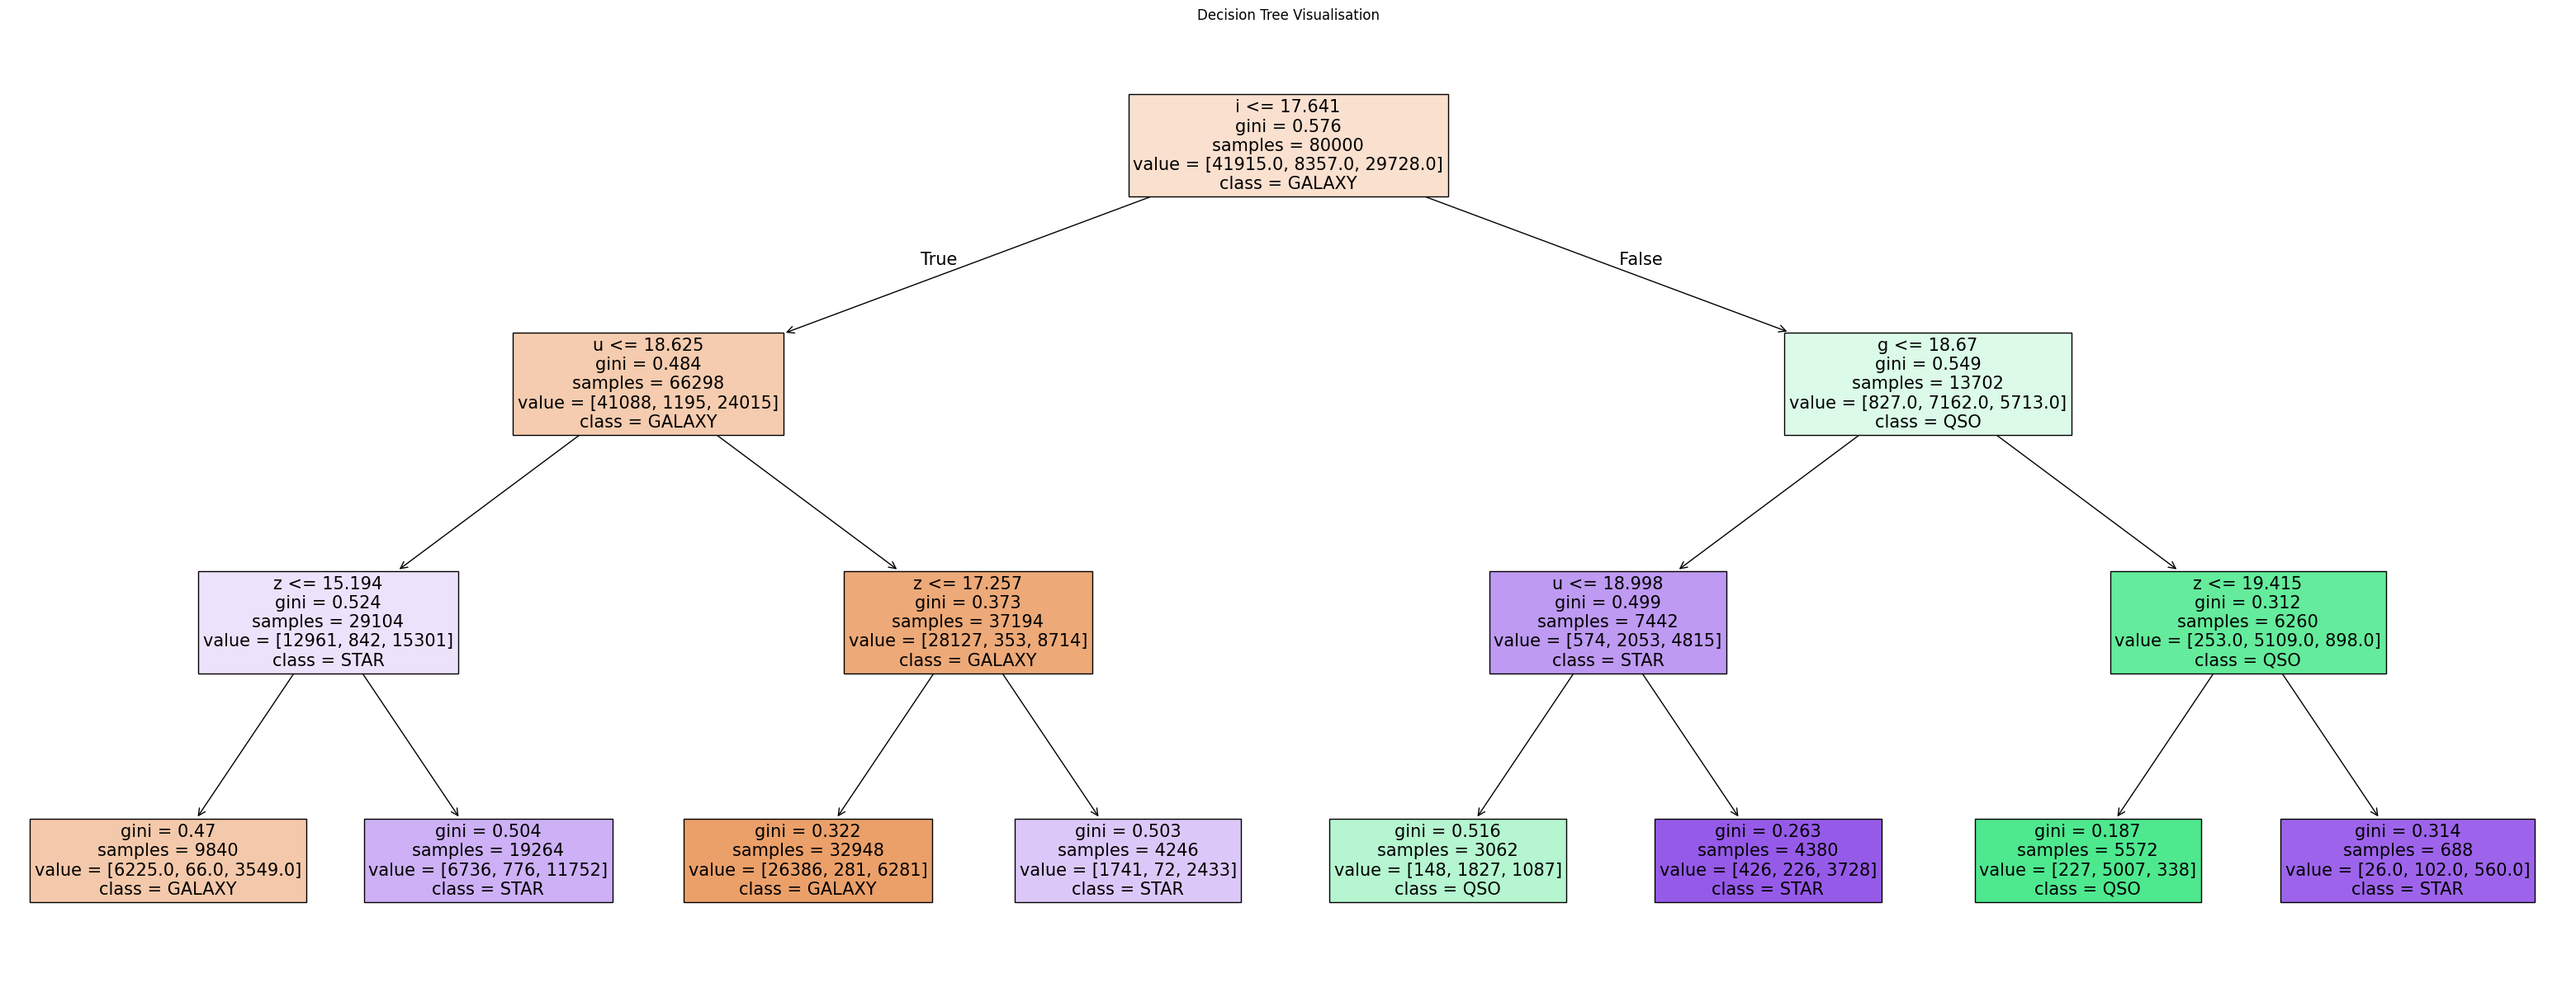

In [8]:
plt.figure(figsize=(40, 15))
plt_tree(clf, feature_names=features.columns, class_names=clf.classes_, filled=True, fontsize=15)
plt.title("Decision Tree Visualisation")
plt.show()

To visualise the accuracy of the model, we can utilise a confusion matrix, this displays the **True Label** and the **Predicted Label** and shows where the model more and less accurately predicts classes. Our model using a *max_depth* of 3 is most accurate at predicting Quasars, despite the lesser number of them, and least accurate at predicting stars - with stars being most prominently being miss-classed as galaxies - likely due to the fact that galaxies are a large collection of stars, so will often optically look similar in terms of the visual data available to us - with quasars being a lot more unique.

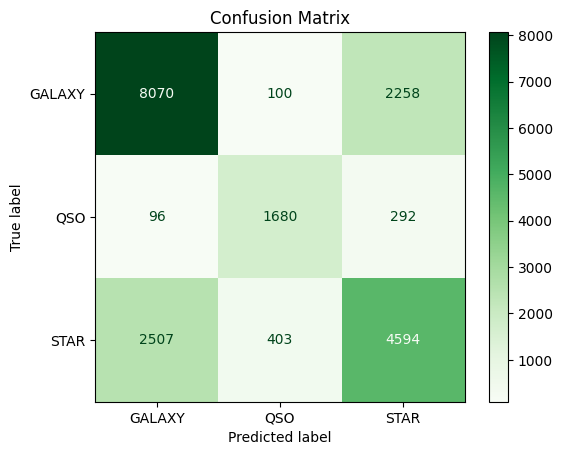

In [9]:
conf_mat = confusion_matrix(yTest, yPred)

display = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=clf.classes_)
display.plot(cmap=plt.cm.Greens, values_format='d')

plt.title("Confusion Matrix")
plt.show()

## Improving our model ##

In order to better fit our model, we run the *decision tree classifier* a number of times to best determine the *max_depth* parameter. By doing this, we can refine our model to most accurately predict the class without under or overfitting - something we begin to determine below.

In [10]:
clfDepth2 = decisionTreeController(xTrain, yTrain, 2, random_state)

#we skip max_depth = 3 as this has been done before as clf

clfDepth4 = decisionTreeController(xTrain, yTrain, 4, random_state)

clfDepth5 = decisionTreeController(xTrain, yTrain, 5, random_state)

clfDepth6 = decisionTreeController(xTrain, yTrain, 6, random_state)

clfDepth7 = decisionTreeController(xTrain, yTrain, 7, random_state)

We then can plot these decision trees - you won't be able to read these given the number of nodes and leaves of each tree so don't worry too much - we just wish to visualise these to show how depth changes the tree. With these we can now take a look at the accuracy of the model by varying the *max_depth* and see which fits best!

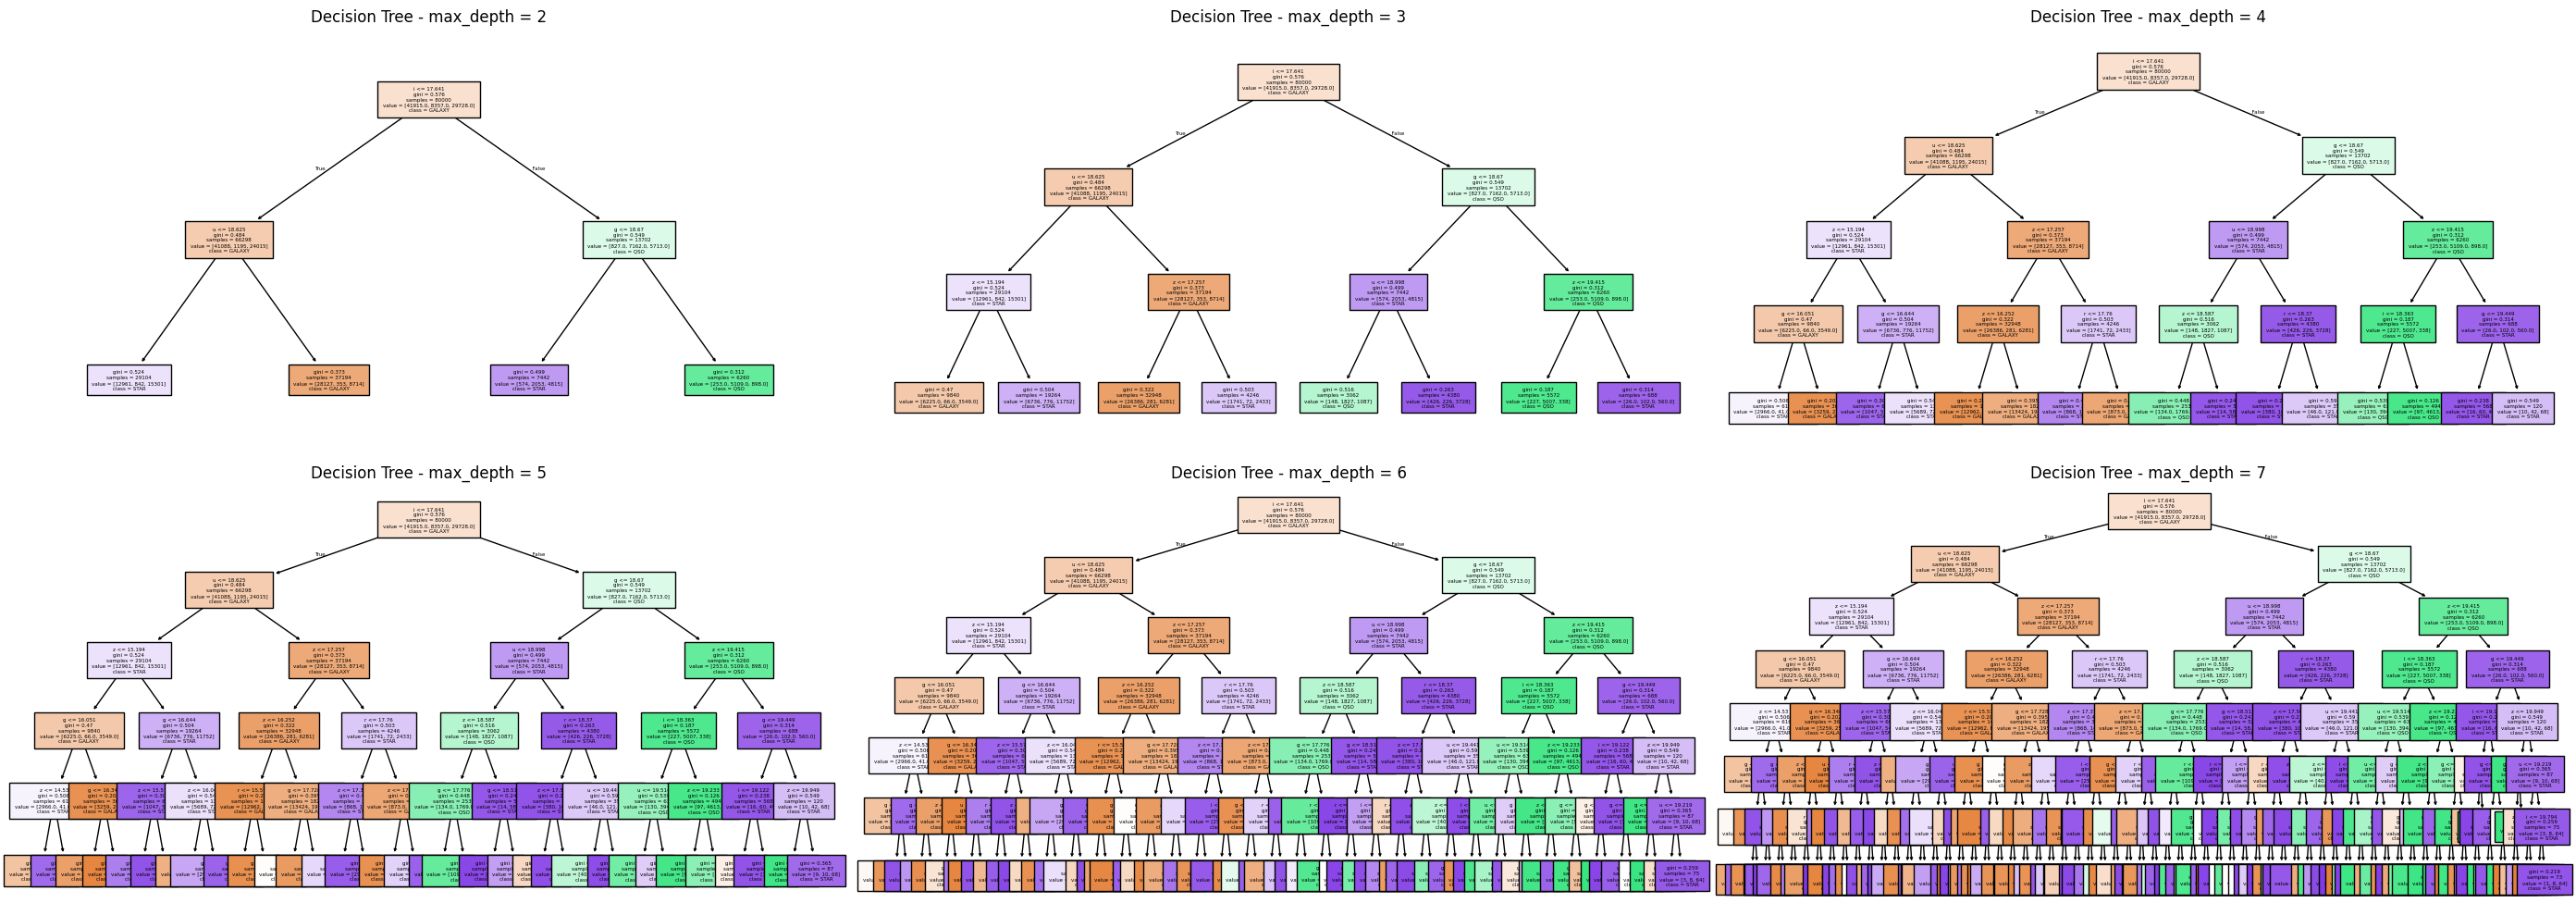

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(28, 10))
axes = axes.flatten()
estimators = [clfDepth2, clf, clfDepth4, clfDepth5, clfDepth6, clfDepth7]
depths = [2, 3, 4, 5, 6, 7,]
for i, est in enumerate(estimators):
    plt_tree(est, feature_names=features.columns, class_names=est.classes_, filled=True, fontsize=4, ax=axes[i])
    axes[i].set_title(f"Decision Tree - max_depth = {depths[i]}")
plt.tight_layout()
plt.show()

We can now display the accuracy of each model, as shown below, by showing the classification report of each decision tree with each associated **max_depth** - with the least accurate being at a **max_depth = 2**, and the most accurate at a **max_depth = 7**. This however, doesn't mean that the model at max_depth = 7 is the best fit for this data, as it very well could be overfitting and may behave differently with a different dataset to find the classes.

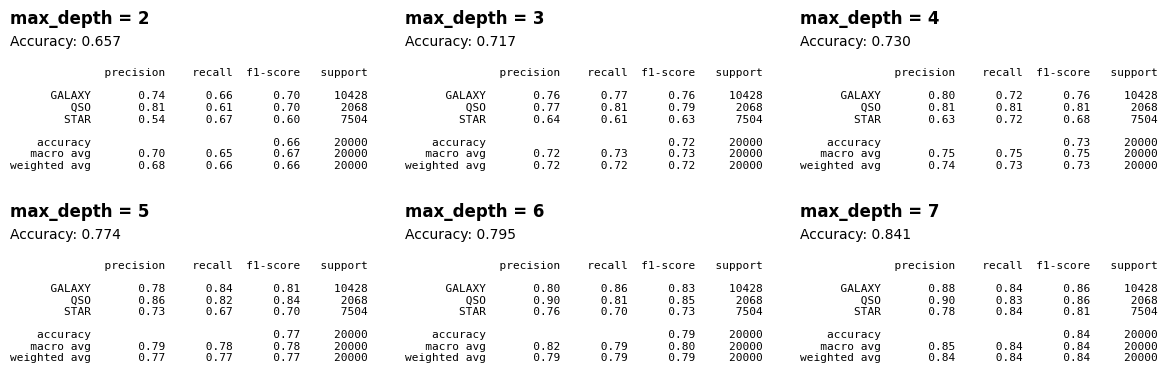

In [12]:
estimators = [clfDepth2, clf, clfDepth4, clfDepth5, clfDepth6, clfDepth7]
depths = [2, 3, 4, 5, 6, 7]
fig, axes = plt.subplots(2, 3, figsize=(12, 4))
axes = axes.flatten()
for i, est in enumerate(estimators):
    y_pred = est.predict(xTest)
    report = skl_cr(yTest, y_pred, labels=clf.classes_)
    acc = skl_as(yTest, y_pred)
    axes[i].axis('off')
    axes[i].text(0, 0.95, f"max_depth = {depths[i]}", fontsize=12, weight='bold')
    axes[i].text(0, 0.82, f"Accuracy: {acc:.3f}", fontsize=10)
    axes[i].text(0, 0.02, report, fontsize=8, family='monospace', va='bottom')
plt.tight_layout()
plt.show()

We can then show the confusion matrix of each of these trees, showing the accuracy of each model and determine which is most accurate to determine the class of each object!

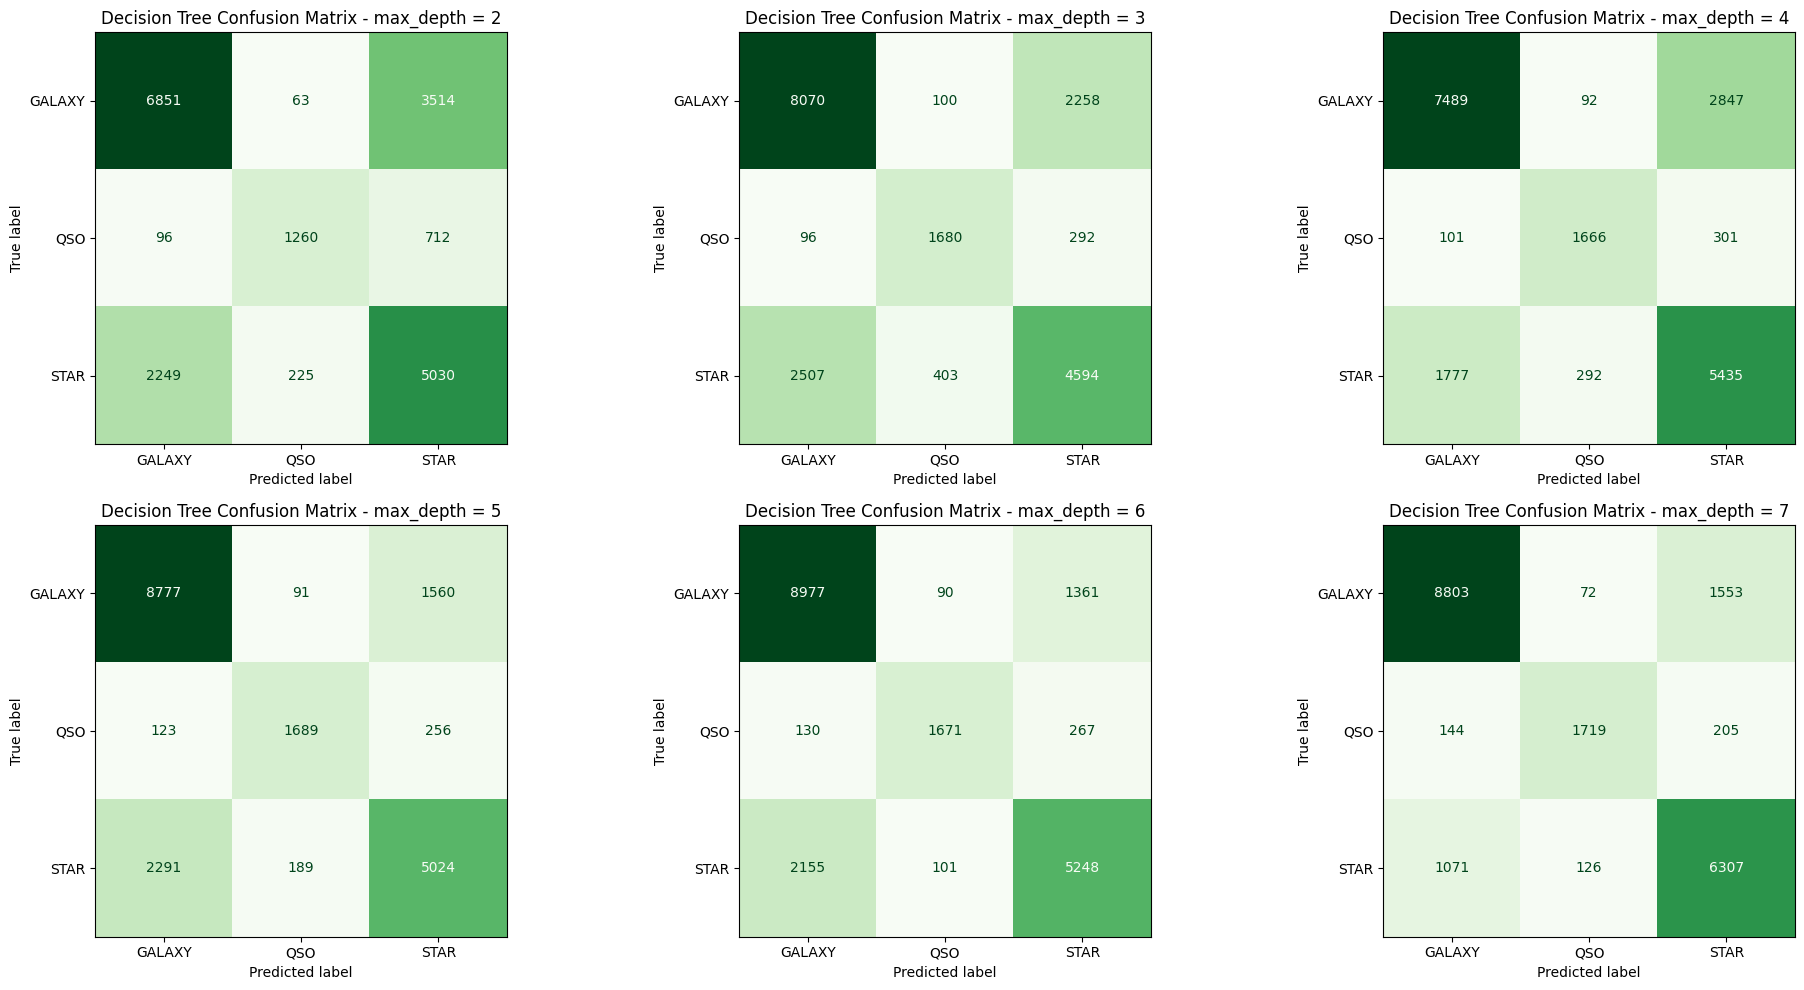

In [13]:
estimators = [clfDepth2, clf, clfDepth4, clfDepth5, clfDepth6, clfDepth7]
depths = [2, 3, 4, 5, 6, 7]
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, est in enumerate(estimators):
    y_pred = est.predict(xTest)
    cm = confusion_matrix(yTest, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(ax=axes[i], cmap=plt.cm.Greens, values_format='d', colorbar=False)
    axes[i].set_title(f"Decision Tree Confusion Matrix - max_depth = {depths[i]}")

plt.tight_layout()
plt.show()

Curiously, the model more accurately determines each class type at different depths. For Galaxies, these are best identified at **max_depth = 6** - for Stars and Quasars, this is at **max_depth = 7**. Based upon this, we can determine that the model is likely beginning to overfit around a **max_depth = 6** - however there are many other parameters we can apply to best prevent overfitting and make our model better, for instance the minimum number of samples per split, or per leaf **(min_samples_split and min_samples_leaf)** - things we will discuss further in the Q3 notebook!